### Importing required libraries

In [ ]:
# Imported libraries
import numpy as np
import imageio
import scipy
import scipy.ndimage
import sys
import matplotlib.pyplot as plt
from skimage import morphology
from PIL import Image
from IPython.display import Image as Image2

### Generating a Braille Image
Given an input sentence, and with the help of the dictionary, the code generates an image containing the sentence in the Braille system.

In [ ]:
# Function that generates a braille image
def generate_braille_image(word):
    letters = [Image.open(x) for x in ['/content/a.png', '/content/b.png', '/content/c.png', '/content/d.png',
                                       '/content/e.png', '/content/f.png', '/content/g.png', '/content/h.png',
                                       '/content/i.png', '/content/j.png', '/content/k.png', '/content/l.png',
                                       '/content/m.png', '/content/n.png', '/content/o.png', '/content/p.png',
                                       '/content/q.png', '/content/r.png', '/content/s.png', '/content/t.png',
                                       '/content/u.png', '/content/v.png', '/content/w.png', '/content/x.png',
                                       '/content/y.png', '/content/z.png', '/content/_space.png'
                                      ]]

    images = []
    for letter in word:
        if letter != ' ':
            images.append(letters[ord(letter)-ord('a')])
        else: images.append(letters[26])
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]

    word_chunks = word.split(' ')
    img_name = word_chunks[0] +'.png'
    new_im.save(img_name)

    return img_name

In [ ]:
img_name5 = generate_braille_image("Sunil Kumar Sir ")

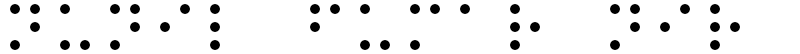

In [ ]:
Image2(filename=img_name5)

###  Preprocessing and quantisation
After performing the image generation, we will transform the image to grayscale using the Luminance method. Afterwards, as the image has only two colors, black and white, we will quantize the image to use only 1 bit, which will help us to make subsequent calculations more efficient. Finally, we apply the closing function.

#### Function declarations

In [ ]:
# Function that generates a image just with shades of gray, applying weights in each RGB component based on
# Luminance technique
def To_grayscale(img):
    imgA = np.floor(img[:,:,0] * 0.299 + img[:,:,1] * 0.587 + img[:,:,2] * 0.114)
    imgA = imgA.astype('uint8')
    return imgA

In [ ]:
# Function that generates a image with scale values in interval [0, (2^b)-1]
def Quantisation (img, b):
    img = np.right_shift(img, 8-b)
    return img

In [ ]:
# Function that calls grayscale and quantisation and apply closing with a disk of 4, generating a result image
def applying_filters(img, bits):
    img = To_grayscale(img)
    img = Quantisation(img, bits)
    img = morphology.closing(img, morphology.disk(4)).astype(np.uint8)
    return img

#### Reading and applying the functions on the image

In [ ]:
# Menu of options
print(" - Enter 0 if you want to use an image already available in our database (under \"images/...\")")
print(" - Enter 1 if you want to generate the image with our braille text generator")

function = input()
menu = False

while(menu == False):
    if function == '0':
        img_name = input().rstrip() # read reference image's name
        menu = True
    elif function == '1':
        print("Type a word or sentence to create braille image.")
        word = input().rstrip()
        img_name = generate_braille_image(word)
        menu = True
    else:
        print("Try again")
        function = input()


img_b = imageio.imread(img_name)
img = applying_filters(img_b, 1)

 - Enter 0 if you want to use an image already available in our database (under "images/...")
 - Enter 1 if you want to generate the image with our braille text generator
Sunil Kumar Sir
Try again
sunil kumar sir
Try again
1
Type a word or sentence to create braille image.
Sunil Kumar Sir


<ipython-input-20-dd622d951d45>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_b = imageio.imread(img_name)


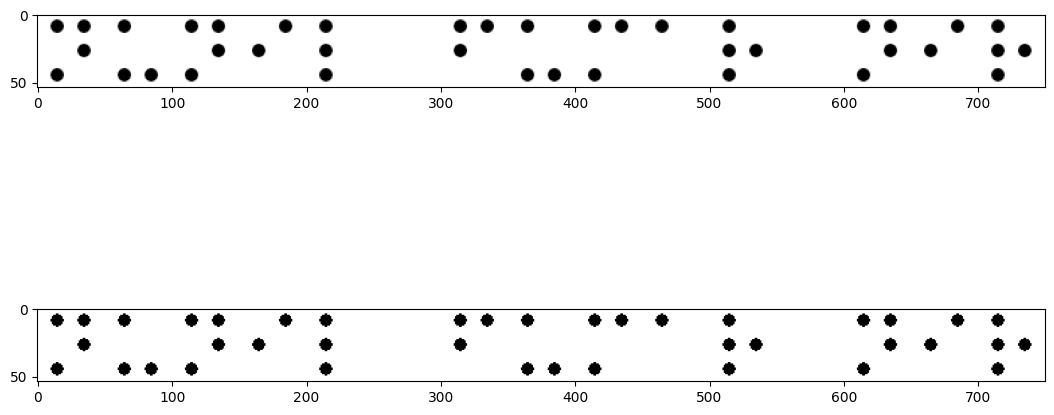

In [ ]:
# Let's show the difference and importance of applying pre-processing
f, axarr = plt.subplots(2, 1)
f.set_size_inches(13, 7)
axarr[0].imshow(img_b, cmap="gray", vmin=0, vmax=255)
axarr[1].imshow(img, cmap="gray", vmin=0, vmax=1)
plt.show()

### Applying the functions to the reference points

To identify each letter, we will use two reference images: one representing the left dots of each Braille letter, and one representing the right dots. For this, we will read both and apply the same functions that we applied to the image that contains the sentence.

In [ ]:
# Reading and pre-processing another important part of our work: the dot symbol
dot_left_b = imageio.imread("/content/_left_dot.png")
dot_right_b = imageio.imread("/content/_right_dot.png")

dot_left = applying_filters(dot_left_b, 1)
dot_right = applying_filters(dot_right_b, 1)

<ipython-input-22-18d341aa8f39>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dot_left_b = imageio.imread("/content/_left_dot.png")
<ipython-input-22-18d341aa8f39>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dot_right_b = imageio.imread("/content/_right_dot.png")


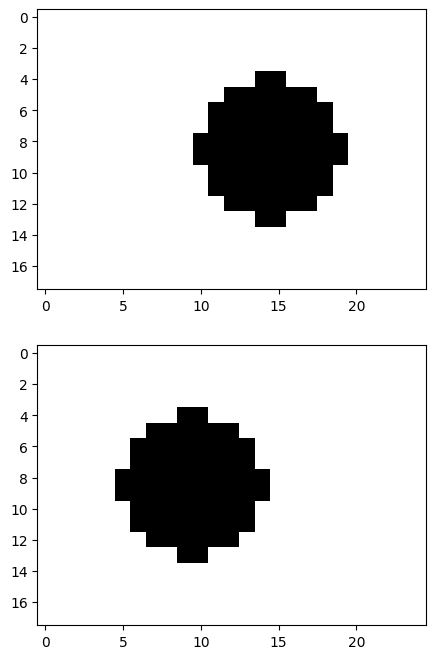

In [ ]:
f, axarr = plt.subplots(2, 1)
f.set_size_inches(18, 8)
axarr[0].imshow(dot_left, cmap="gray", vmin=0, vmax=1)
axarr[1].imshow(dot_right, cmap="gray", vmin=0, vmax=1)
plt.show()

### Dividing the image into blocks
We know that each letter is $50px$ wide, and that the image width is $M$. So, we will split our image into $\frac{M}{50}$ blocks (where each block will represent a letter). As each Braille letter is represented by up to 6 dots, we will divide each letter into 6 smaller blocks, each one having a place that can have a dot. So, in total, we will have $\frac{(6M)}{50}$ windows that will be compared with the *dot_left* and *dot_right* images.

![title](images/letter_value.png)

In [ ]:
# Function that creates 6 windows, separating each dot region
def letter_representation(img, bits):

    N,M = img.shape
    windows = np.empty((int(M/50)*6, 18, 25))

    a = 0
    for i in range (0, M-1, 50): # creating windows
            temp_wind = img[:,i:i+50]
            n,m = temp_wind.shape
            windows[a] = temp_wind[:int(n/3),:int(m/2)] # 1
            windows[a+1] = temp_wind[:int(n/3),int(m/2):m] # 01
            windows[a+2] = temp_wind[int(n/3):int(2*n/3),:int(m/2)] # 00/1
            windows[a+3] = temp_wind[int(n/3):int(2*n/3),int(m/2):m] # 00/01
            windows[a+4] = temp_wind[int(2*n/3):n,:int(m/2)] # 00/00/1
            windows[a+5] = temp_wind[int(2*n/3):n,int(m/2):m] # 00/00/01
            a += 6

    return windows

### Euclidean distance calculation
To compare the windows that were created earlier with the *dot_left* and *dot_right* images, we will use the Euclidean distance, which calculates the line segment between the two points, and then add all the values.

In [ ]:
# Function that calculates Euclidean distance between
def Difference(a, b):
    np.seterr(all='ignore')
    return np.sqrt(np.sum((a-b)**2))

### Finding the shortest distance
Here, we will build a matrix of size $\frac{M}{50}$ (number of letters in the image) by $6$. Each row will represent a letter present in our image, and each column a dot. If the position is $0$, that window does not have a dot, if the position has the value $1$, a dot has been identified. The representation of each point is carried out as follows:

In [ ]:
# Function that compares each dot region with left and right dot images, using Euclidean distance. If the result
# is lower than 0.0001, we have a dot there, so we gonna say that in this sector the result is 1.
# After all six comparisons, the function generates and returns an array showing the regions and their results.
def shortestDistance(windows, left, right, M):
    min_dist = sys.maxsize
    close = -1
    text = [[0]*6]

    # calculating the distances and finding the closest window
    a = 0
    for y in range (int(M/50)):
        letter_value = np.zeros((1,6), dtype=np.int8)
        for i in range(6):
            if Difference(left, windows[a+i]) <= 0.0001 or Difference(right, windows[a+i]) <= 0.0001:
                letter_value[0][i] = 1

        text = np.append(text, letter_value, axis=0)
        a += 6

    return text

In [ ]:
# Let's check with the word that you choose!
# With output in this cell, we have the array where each line shows the word representation.
M, N = img.shape

windows = letter_representation(img, 1)
text_value = shortestDistance(windows, dot_left, dot_right, N)[1:]
print("Dot representation matrix:")
print(text_value)

Dot representation matrix:
[[1 1 0 1 1 0]
 [1 0 0 0 1 1]
 [1 1 0 1 1 0]
 [0 1 1 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]
 [1 1 1 0 0 0]
 [1 0 0 0 1 1]
 [1 1 0 0 1 0]
 [1 0 0 0 0 0]
 [1 0 1 1 1 0]
 [0 0 0 0 0 0]
 [1 1 0 1 1 0]
 [0 1 1 0 0 0]
 [1 0 1 1 1 0]]


### Generating the dictionary
Using the same logic as before, here we generate a 6-position vector for each letter of the alphabet, so that we can identify in the *text_value* matrix calculated above, which letter each vector represents.

In [ ]:
# To compare our array, we need to do the same with the dictionary
dic = {}
alphabet = ['dictionary/a.png', 'dictionary/b.png', 'dictionary/c.png', 'dictionary/d.png', 'dictionary/e.png',
            'dictionary/f.png', 'dictionary/g.png', 'dictionary/h.png', 'dictionary/i.png', 'dictionary/j.png',
            'dictionary/k.png', 'dictionary/l.png', 'dictionary/m.png', 'dictionary/n.png', 'dictionary/o.png',
            'dictionary/p.png', 'dictionary/q.png', 'dictionary/r.png', 'dictionary/s.png', 'dictionary/t.png',
            'dictionary/u.png', 'dictionary/v.png', 'dictionary/w.png', 'dictionary/x.png', 'dictionary/y.png',
            'dictionary/z.png'
           ]

for temp in alphabet:
    temp_img = imageio.imread(temp)
    temp_img = applying_filters(temp_img, 1)
    M, N = temp_img.shape
    temp_img = letter_representation(temp_img, 1)
    dic[temp[11]] = list(shortestDistance(temp_img, dot_left, dot_right, M)[1])
dic[' '] = [0,0,0,0,0,0]

print(dic)

<ipython-input-28-14103f76e837>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  temp_img = imageio.imread(temp)


FileNotFoundError: No such file: '/content/dictionary/a.png'

### Final Result
Finally, with the vector and dictionary calculated, simply relate them to generate the final text.

In [ ]:
# Lastly, we search for each letter representation in dictionary and generates the final text
final_text = ""
for i in range(text_value.shape[0]):
    for key, values in dic.items():
        if(list(text_value[i]) == list(values)):
            final_text += key

print("Translated text:", final_text)